In [1]:
%load_ext autoreload
%autoreload 2

from nb_002b import *

In [2]:
import operator
from random import sample

from torch.utils.data.sampler import Sampler

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'caltech101'

# Caltech 101

## Create validation set

In [4]:
#export
class FilesDataset(Dataset):
    def __init__(self, fns, labels, classes=None):
        if classes is None: classes = list(set(labels))
        self.classes = classes
        self.class2idx = {v:k for k,v in enumerate(classes)}
        self.fns = np.array(fns)
        self.y = [self.class2idx[o] for o in labels]
        
    @classmethod
    def from_folder(cls, folder, classes=None, test_pct=0.):
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            fnames = get_image_files(folder/cl)
            fns += fnames
            labels += [cl] * len(fnames)
            
        if test_pct==0.: return cls(fns, labels)
        fns,labels = np.array(fns),np.array(labels)
        is_test = np.random.uniform(size=(len(fns),)) < test_pct
        return cls(fns[~is_test], labels[~is_test]), cls(fns[is_test], labels[is_test])

    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [5]:
classes = ['airplanes','Motorbikes','Faces','watch','Leopards']
np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, classes=classes, test_pct=0.2)

x = train_ds[3][0]

In [6]:
len(train_ds),len(valid_ds)

(1951, 521)

## Rectangular affine fix

torch.Size([3, 133, 399])


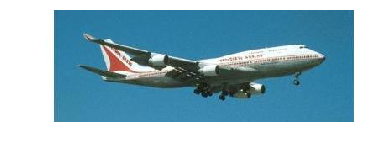

In [7]:
show_image(x, figsize=(6,3))
print(x.shape)

In [8]:
rot_m = np.array(rotate(20.)); rot_m

array([[ 0.93969262, -0.34202014,  0.        ],
       [ 0.34202014,  0.93969262,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

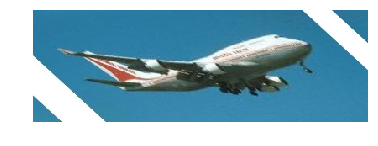

In [9]:
show_image(apply_affine(rot_m)(x), figsize=(6,3))

In [10]:
def affine_grid(x, matrix, size=None):
    h,w = x.shape[1:]
    if size is None: size=x.shape
    matrix[0,1] *= h/w; matrix[1,0] *= w/h
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

import nb_002
nb_002.affine_grid = affine_grid

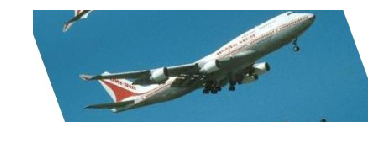

In [11]:
show_image(apply_affine(rot_m)(x), figsize=(6,3))

## Crop with padding

In [ ]:
TfmType = IntEnum('TfmType', 'Start Affine Coord Pixel Lighting Crop')

In [396]:
@reg_transform
def crop_pad(x, size, padding_mode='reflect',
             row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Crop:
    size = listify(size,2)
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=padding_mode)[0]
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)

    x = x[:, row:row+rows, col:col+cols]
    return x.contiguous()

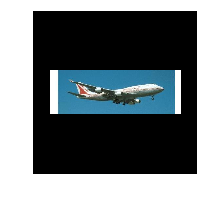

In [398]:
show_image(crop_pad(x, 500, row_pct=0.,col_pct=0., padding_mode='constant'))

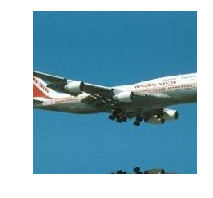

In [399]:
show_image(crop_pad(x, 200))

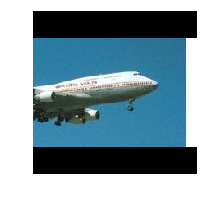

In [400]:
show_image(crop_pad(x, 200, row_pct=0.,col_pct=0.98, padding_mode='constant'))

## Combine crop/resize

In [401]:
_,r,c = x.shape; x.shape

torch.Size([3, 133, 399])

In [402]:
def get_crop_target(target_aspect, target_px):
    target_px = listify(target_px, 2)
    target_r = int(math.sqrt(target_px[0]*target_px[1]/target_aspect))
    target_c = int(target_r*target_aspect)
    return target_r,target_c

In [403]:
crop_target = get_crop_target(2, 200);
target_r,target_c = crop_target; crop_target

(141, 282)

In [404]:
r_ratio = r/target_r
c_ratio = c/target_c
# min -> crop; max -> pad
ratio = max(r_ratio,c_ratio)
r_ratio,c_ratio,ratio

(0.9432624113475178, 1.4148936170212767, 1.4148936170212767)

In [405]:
r2,c2 = round(r/ratio),round(c/ratio); r2,c2

(94, 282)

In [406]:
def get_resize_target(img, crop_target, do_crop=False):
    if crop_target is None: return None
    ch,r,c = img.shape
    target_r,target_c = crop_target
    ratio = (min if do_crop else max)(r/target_r, c/target_c)
    return ch,round(r/ratio),round(c/ratio)

In [407]:
get_resize_target(x, crop_target, False)

(3, 94, 282)

In [408]:
get_resize_target(x, crop_target, True)

(3, 141, 423)

In [411]:
def apply_affine(m=None, func=None, crop_func=None):
    def _inner(img, size=None, padding_mode='reflect', do_crop=False, **kwargs):
        if m is None:
            if func is None and size is None: return img
            else: m2=torch.eye(3)
        else:
            m2 = img.new_tensor(m)
        resize_target = get_resize_target(img, size, do_crop=do_crop)
        c = affine_grid(img, m2, size=resize_target)
        if func is not None: c = func(c)
        res = grid_sample(img, c, padding_mode=padding_mode, **kwargs)
        if padding_mode=='zeros': padding_mode='constant'
        if crop_func is not None: res = crop_func(res, size=size, padding_mode=padding_mode)
        return res
    return _inner

torch.Size([3, 94, 282])

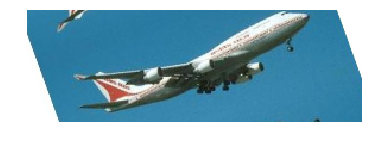

In [413]:
img = apply_affine(rot_m)(x, size=crop_target, do_crop=False)
show_image(img, figsize=(6,3))
img.shape

torch.Size([3, 141, 282])

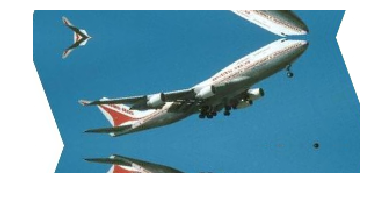

In [414]:
img = apply_affine(rot_m, crop_func=crop_pad)(x, do_crop=False, size=crop_target)
show_image(img, figsize=(6,3))
img.shape

torch.Size([3, 141, 282])

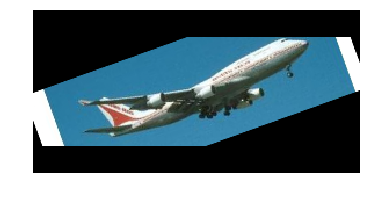

In [415]:
img = apply_affine(rot_m, crop_func=crop_pad)(x, do_crop=False, size=crop_target, padding_mode='zeros')
show_image(img, figsize=(6,3))
img.shape

## crop_pad_tfm

In [416]:
def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.__annotations__['return'])
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms,crop_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    crop_func = compose(crop_tfms)
    affine_func = apply_affine(
        affines_mat(affine_tfms), func=compose(coord_tfms), crop_func=crop_func)
    start_func = compose(start_tfms)
    pixel_func = compose(pixel_tfms)
    def _inner(x, **kwargs):
        res = affine_func(start_func(x.clone()), **kwargs)
        return pixel_func(lighting_func(res))
    return _inner

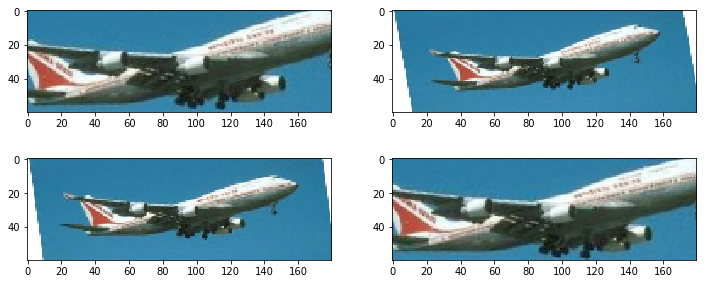

In [417]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.95)),
]

_,axes = plt.subplots(2,2, figsize=(12,5))
for ax in axes.flat:
    show_image(apply_tfms(tfms)(x, do_crop=True, size=(60,100)), ax, hide_axis=False)

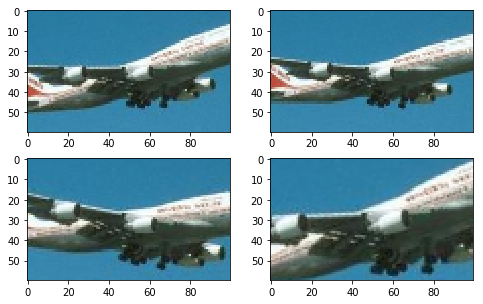

In [426]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.95)),
    crop_pad_tfm()
]

_,axes = plt.subplots(2,2, figsize=(8,5))
for ax in axes.flat:
    show_image(apply_tfms(tfms)(x, do_crop=True, size=(60,100)), ax, hide_axis=False)

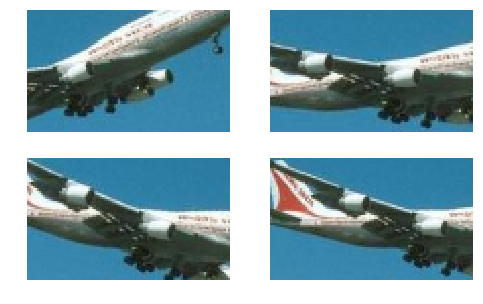

In [427]:
tfms = [
    rotate_tfm(degrees=(-20,20.)),
    zoom_tfm(scale=(1.,1.95)),
    crop_pad_tfm(row_pct=(0,1.), col_pct=(0,1.))
]

_,axes = plt.subplots(2,2, figsize=(8,5))
for ax in axes.flat:
    show_image(apply_tfms(tfms)(x, do_crop=True, size=(60,100)), ax)

# Rectangular data loader

## Resize / crop

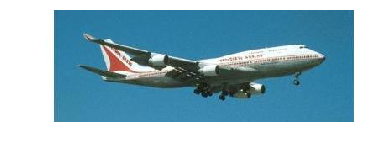

In [180]:
show_image(train_ds[3][0], figsize=(6,3))

In [202]:
x.shape

torch.Size([3, 133, 399])

In [368]:
asp_ratios = [operator.truediv(*Image.open(fn).size) for fn in train_ds.fns]
asp_ratios[:4]

[3.2338709677419355, 2.36144578313253, 1.7743362831858407, 3.0]

In [335]:
asp_ntiles = np.percentile(asp_ratios, [2,20,50,80,98])
asp_ntiles

array([0.75      , 1.5       , 1.62804878, 2.48148148, 3.184     ])

In [ ]:
def closest_ntile(aspect, ntiles):
    return ntiles[np.argmin(abs(log(aspect)-log(ntiles)))]

In [373]:
aspect = x.shape[2]/x.shape[1]
nearest_aspect = closest_ntile(aspect, asp_ntiles)
aspect,nearest_aspect

(3.0, 3.184)

In [374]:
target_px = 128*128; target_px

16384

In [381]:
target_r = int(math.sqrt(target_px/nearest_aspect))
target_c = int(target_r*nearest_aspect)
target_r,target_c,target_r*target_c

(71, 226, 16046)

## SortAspectBatchSampler

In [340]:
asp_nearests = [closest_ntile(o, asp_ntiles) for o in asp_ratios]
asp_nearests[:10]

[3.184,
 2.4814814814814814,
 1.6280487804878048,
 3.184,
 1.6280487804878048,
 2.4814814814814814,
 2.4814814814814814,
 3.184,
 2.4814814814814814,
 3.184]

In [ ]:
bs=32

In [348]:
sort_nearest = sorted(enumerate(asp_nearests), key=itemgetter(1))
groups = [list(b) for a,b in groupby(sort_nearest, key=itemgetter(1))]
len(groups)

5

In [353]:
groups[0][:5]

[(186, 0.75), (475, 0.75), (744, 0.75), (1599, 0.75), (1602, 0.75)]

In [350]:
sum(math.ceil(len(g)/bs) for g in groups)

63

In [439]:
@dataclass
class SortAspectBatchSampler(Sampler):
    ds: Dataset
    bs: int
    shuffle: bool = False
    def __post_init__(self):
        asp_ratios = [operator.truediv(*Image.open(img).size) for img in self.ds.fns]
        asp_ntiles = np.percentile(asp_ratios, [2,20,50,80,98])
        asp_nearests = [closest_ntile(o, asp_ntiles) for o in asp_ratios]
        sort_nearest = sorted(enumerate(asp_nearests), key=itemgetter(1))
        self.groups = [list(b) for a,b in groupby(sort_nearest, key=itemgetter(1))]
        self.n = sum(math.ceil(len(g)/bs) for g in self.groups)

    def __len__(self): return self.n
    
    def __iter__(self):
        if self.shuffle: self.groups = sample(self.groups, len(self.groups))
        for group in self.groups:
            if self.shuffle: group = sample(group, len(group))
            for i in range(0, len(group), self.bs): yield group[i:i+self.bs]

In [440]:
next(iter(SortAspectBatchSampler(train_ds, 4)))

[(186, 0.75), (475, 0.75), (744, 0.75), (1599, 0.75)]

In [443]:
next(iter(SortAspectBatchSampler(train_ds, 4, True)))

[(381, 3.184), (396, 3.184), (251, 3.184), (454, 3.184)]

## Rectangular dataset

In [585]:
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable]
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        if isinstance(idx, tuple): idx,aspect = idx
        else: aspect=None
        x,y = self.ds[idx]
        return resolve_pipeline(tfms, aspect=aspect)(x),y

In [364]:
@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform, mode='reflect') -> TfmType.Final:
    size = listify(size,2)
    rows,cols = size
    if x.size(1)<rows or x.size(2)<cols:
        row_pad = max((rows-x.size(1)+1)//2, 0)
        col_pad = max((cols-x.size(2)+1)//2, 0)
        x = F.pad(x[None], (col_pad,col_pad,row_pad,row_pad), mode=mode)[0]
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)

    res = x[:, row:row+rows, col:col+cols]
    return res

In [576]:
def resolve_pipeline(tfms, **kwargs):
    if len(tfms)==0: return noop
    grouped_tfms = dict_groupby(tfms, lambda o: o.__annotations__['return'])
    lighting_tfms,coord_tfms,affine_tfms,pixel_tfms,final_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_tfm = apply_lighting_tfm(compose(lighting_tfms))
    affine_tfm = apply_affine_tfm(affine_tfms, func=compose(coord_tfms), **kwargs)
    final_tfm = compose(final_tfms)
    pixel_tfm = compose(pixel_tfms)

    return lambda x,**k: lighting_tfm(final_tfm(affine_tfm(pixel_tfm(x.clone()), **k)))

In [582]:
tfms = [
    rotate_tfm(degrees=(-20,20.), p=0.75),
    zoom_tfm(scale=(1.,1.5), p=1.)
]

In [583]:
train_tds = TfmDataset(train_ds, tfms)

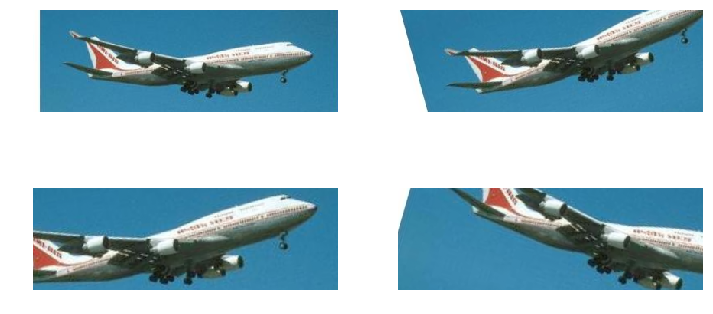

In [584]:
_,axes = plt.subplots(2,2, figsize=(12,6))
for ax in axes.flat: show_image(train_tds[3][0], ax)

# Test

## TransformBunch

In [188]:
tfms = [
    crop_tfm(size=100)
]

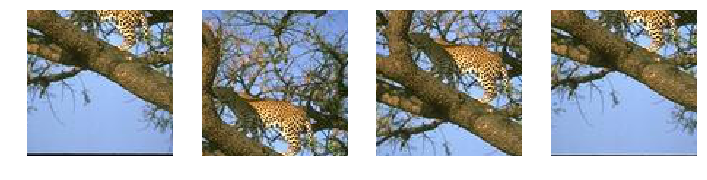

In [189]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(resolve_pipeline(tfms)(x()), ax)

In [42]:
train_tfms = [
    flip_lr_tfm(p=0.5),
    rotate_tfm(degrees=(-10,10.), p=0.5),
    zoom_tfm(scale=(0.9,1.1), p=0.5),
    contrast_tfm(scale=(0.8,1.2)),
    brightness_tfm(change=(0.4,0.6)),
    crop_tfm()
]